In [114]:
using CairoMakie
using Makie
using DataFrames
using CSV
using FFTW,DSP

In [2]:
using Damysos

# Some example spectra

In [3]:
avg(x::Vector) = sum(x) / length(x)

avg (generic function with 1 method)

![](zeta=1.0_gamma=2.0.png)

![](zeta=5.0_gamma=2.0.png)

![](zeta=1.0_gamma=0.1.png)

![](zeta=5.0_gamma=0.1.png)

# Routine definitions & setup

In [4]:
function applyhanning(x::Vector) 
    # if iseven(length(x))
    #     pushfirst!(x,x[1])
    # end
    return x .* hanning(length(x))
end

applyhanning (generic function with 1 method)

In [5]:
function extract_tols(input::AbstractString)
    # Define the regular expression pattern
    atolpattern = r"atol: (\d+(\.\d+)?(?:e[-+]?\d+)?)"
    rtolpattern = r"rtol: (\d+(\.\d+)?(?:e[-+]?\d+)?)"
    # Search for matches using regex
    atol_result = match(atolpattern,input)
    rtol_result = match(rtolpattern,input)

    # Check if a match is found
    if isnothing(atol_result) || isnothing(rtol_result)
        println("No parameters found.")
        return nothing
    end

    # Extract parameters from the match
    atol = parse(Float64, atol_result.captures[1])
    rtol = parse(Float64, rtol_result.captures[1])

    # Create a named tuple with extracted parameters
    parameters = (atol=atol, rtol=rtol)

    return parameters
end


extract_tols (generic function with 1 method)

In [6]:
function extract_dt(input::AbstractString)
    # Define the regular expression pattern
    pattern = r"Last(?:[\s\S]*)?dt.*\s?=.* \(([\d.]+(?:e[-+]?\d+)?)\)"
    # Search for matches using regex
    match_result = match(pattern,input)
    # Check if a match is found
    if isnothing(match_result) 
        println("No parameters found.")
        return nothing
    end
    
    return parse(Float64,match_result.captures[1])
end


extract_dt (generic function with 1 method)

In [7]:
function extractpar_lastsim(input::AbstractString,par::String)
    # Define the regular expression pattern
    pattern = Regex("Last(?:[\\s\\S]*)?$par.*\\s?=.* \\(([\\d.]+(?:e[-+]?\\d+)?)\\)")
    # Search for matches using regex
    match_result = match(pattern,input)
    # Check if a match is found
    if isnothing(match_result) 
        println("No parameters found.")
        return nothing
    end
    
    return parse(Float64,match_result.captures[1])
end


extractpar_lastsim (generic function with 1 method)

In [8]:
function extract_values(input_string::String)
    regex_pattern = r"_gamma=(\d+\.\d+)_zeta=(\d+\.\d+)_"
    match_result = match(regex_pattern, input_string)
    
    if match_result === nothing
        error("Pattern not found in input string.")
    end
    
    gamma_value = parse(Float64, match_result.captures[1])
    zeta_value = parse(Float64, match_result.captures[2])
    
    return (gamma_value, zeta_value)
end

extract_values (generic function with 1 method)

In [9]:
function find_files_with_name(root_dir::String, target_name::String)
    file_paths = Vector{String}()
    
    for entry in readdir(root_dir)
        full_path = joinpath(root_dir, entry)
        if isfile(full_path) && occursin(target_name, entry)
            push!(file_paths, full_path)
        elseif isdir(full_path)
            subfiles = find_files_with_name(full_path, target_name)
            append!(file_paths, subfiles)
        end
    end
    
    return file_paths
end

find_files_with_name (generic function with 1 method)

In [10]:
function load_file_content(file_path::AbstractString)
    try
        file_content = read(file_path, String)
        return file_content
    catch err
        println("Error reading file: $err")
        return nothing
    end
end

load_file_content (generic function with 1 method)

In [127]:
path = "/home/richter/phd/data/hhgjl/inter-intra-cancellation"
reportfiles = find_files_with_name(path,"combined-testresult.txt");
files = find_files_with_name(path,"data.csv");

In [102]:
parameters = extract_values.(files);
tols       = extract_tols.(load_file_content.(reportfiles));

# Worst (highest) tolerances achieved

In [10]:
println("Max atol: $(maximum([p.atol for p in tols]))")
println("Max rtol: $(maximum([p.rtol for p in tols]))")
maxpars = parameters[argmax([p.rtol for p in tols])]
println("Worst rtol occured at γ=$(maxpars[1]) ζ=$(maxpars[2])")

Max atol: 1.0e-13
Max rtol: 0.005
Worst rtol occured at γ=1.73 ζ=5.0


## All different rtol's which occured

In [139]:
Set([p.rtol for p in tols])

Set{Float64} with 17 elements:
  0.0005
  0.0003
  0.004000000000000001
  0.00020000000000000004
  0.001
  9.0e-5
  8.0e-5
  0.003
  0.0006000000000000001
  7.000000000000002e-5
  5.0e-5
  0.0001
  0.0007000000000000001
  6.0e-5
  0.0020000000000000005
  0.005
  0.0004000000000000001

# Used grids for achieved tols

In [137]:
Set([extractpar_lastsim(f,"dt") for f in load_file_content.(reportfiles)])

Set{Float64} with 1 element:
  0.005

In [141]:
Set([extractpar_lastsim(f,"dkx") for f in load_file_content.(reportfiles)])

Set{Float64} with 8 elements:
  0.0484
  0.0226
  0.0355
  0.0742
  0.0613
  0.113
  0.1
  0.0872

In [150]:
Set([extractpar_lastsim(f,"kxmax") for f in load_file_content.(reportfiles)])

Set{Float64} with 17 elements:
  169.0
  230.0
  180.0
  253.0
  275.0
  225.0
  247.0
  897.0
  236.0
  242.0
  192.0
  297.0
  264.0
  286.0
  214.0
  203.0
  836.0

# Achieved tolerances for dt sweeps

In [149]:
dtreportfiles = find_files_with_name(path,"dt-testresult.txt");
tols = extract_tols.(load_file_content.(dtreportfiles))
Set([t.rtol for t in tols])

Set{Float64} with 22 elements:
  4.9999999999999996e-6
  2.0000000000000008e-6
  4.000000000000001e-6
  3.0e-7
  9.0e-5
  5.0e-7
  8.0e-5
  6.0e-7
  8.999999999999999e-7
  7.000000000000002e-6
  3.0e-6
  9.0e-6
  3.0000000000000004e-5
  1.0e-6
  5.0e-5
  4.000000000000001e-5
  6.000000000000001e-6
  6.0e-5
  4.0e-7
  8.000000000000001e-6
  2.0000000000000005e-5
  1.0e-5

# Do FFT of data

In [11]:
data = [DataFrame(CSV.File(p)) for p in files];
vxdata = [d.vx for d in data];
vxerdata = [d.vxinter for d in data];
vxradata = [d.vxintra for d in data];
tdata = [d.t for d in data];
dtdata = [sum(diff(ts))/length(ts) for ts in tdata];

In [12]:
fftvx = rfft.(applyhanning.(vxdata));
fftvxer = rfft.(applyhanning.(vxerdata));
fftvxra  = rfft.(applyhanning.(vxradata));
freqs = [periodogram(vx;fs=1/dt).freq for (vx,dt) in zip(vxdata,dtdata)];

In [13]:
length.(fftvx) == length.(freqs)

true

# Plots for DPG talk

## 1st example spectrum

In [115]:
Makie.theme(:fonts)

Attributes with 4 entries:
  bold => TeX Gyre Heros Makie Bold
  bold_italic => TeX Gyre Heros Makie Bold Italic
  italic => TeX Gyre Heros Makie Italic
  regular => TeX Gyre Heros Makie

In [26]:
csvpath = "/home/richter/Desktop/tqt-compare-converged/data.csv"
data    = DataFrame(CSV.File(csvpath));

In [27]:
simpath = "/home/richter/Desktop/tqt-compare-converged/simulation.meta"
sim     = load(simpath);

In [122]:
Makie.to_font("/home/richter/Downloads/fira-sans/FiraSans-Medium.ttf")

FTFont (family = Fira Sans, style = Medium)

In [41]:
dt    = getparams(sim).dt
n     = 4length(sim.observables[1].vx)
vxpdg = periodogram(sim.observables[1].vx,fs=1/dt,nfft=n,window=hanning)
vxerpdg = periodogram(sim.observables[1].vxinter,fs=1/dt,nfft=n,window=hanning)
vxrapdg = periodogram(sim.observables[1].vxintra,fs=1/dt,nfft=n,window=hanning)
fre     = vxpdg.freq;

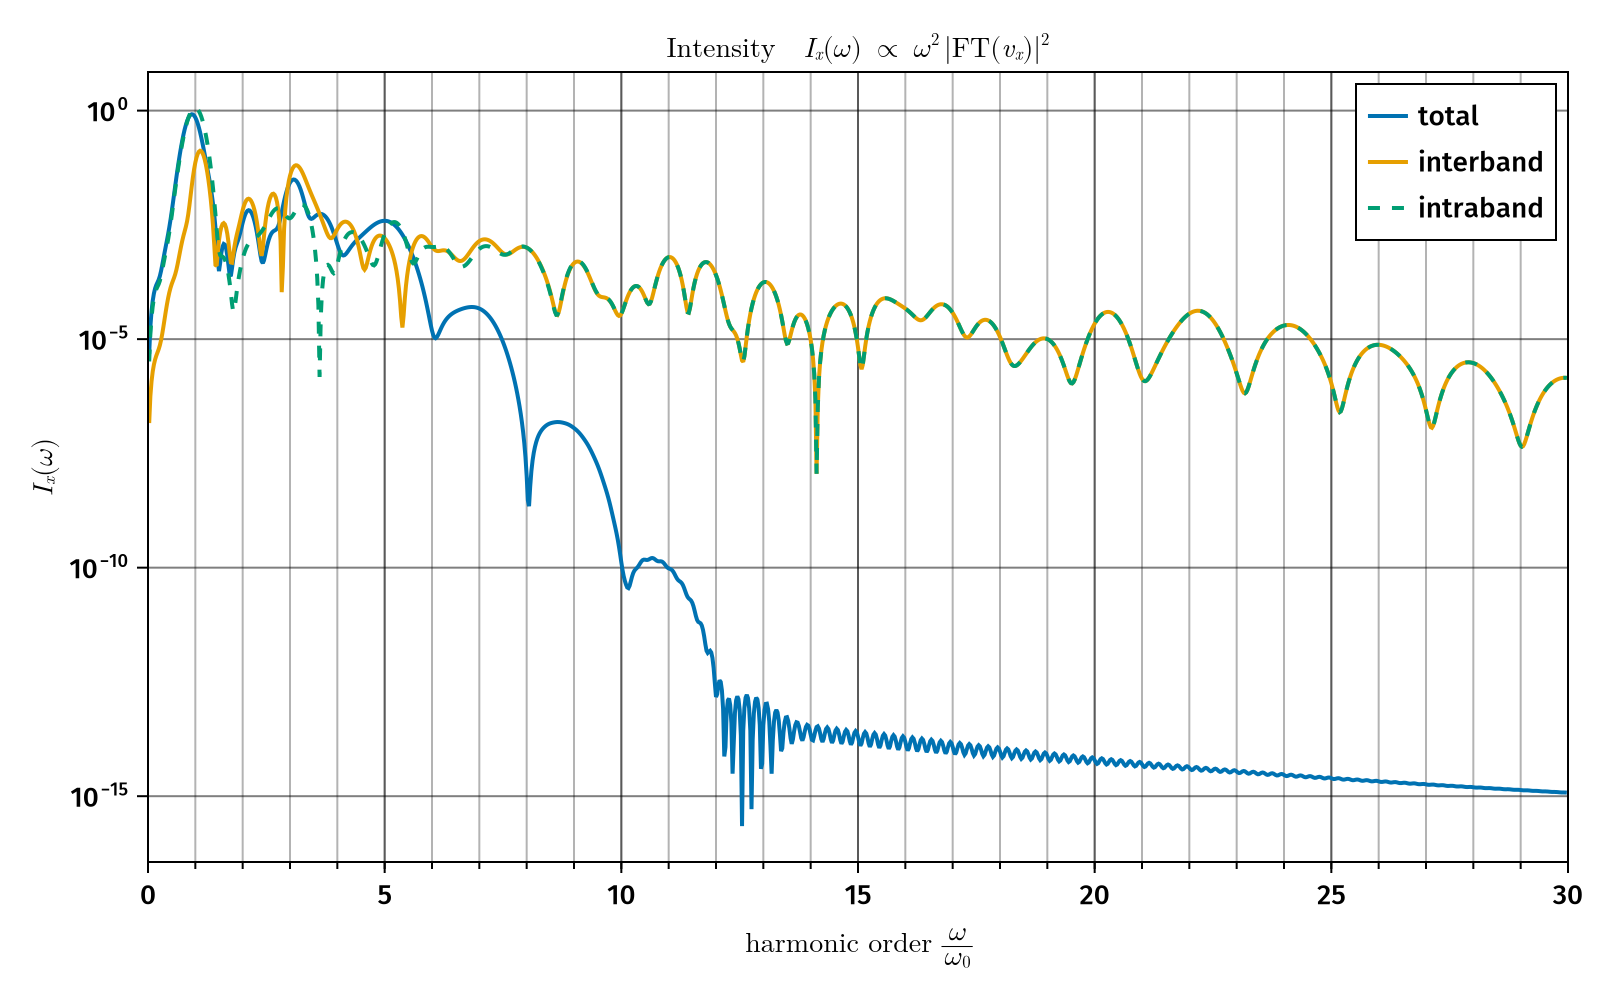

In [124]:
f   = Figure(size=(800,500),fonts = (; regular="/home/richter/Downloads/fira-sans/FiraSans-Medium.ttf"))
maxharm = 30
darkgrey = RGBAf(0,0,0,0.5)
lightgrey = RGBAf(0,0,0,0.3)
ax  = Axis(f[1,1],yscale=log10,xlabel=L"\text{harmonic order } \frac{\omega}{\omega_0}",ylabel=L"I_x(ω)",
    title=L"\text{Intensity   } I_x(\omega)~\propto ~\omega^2\,\left|\text{FT}(v_x)\right|^2",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=lightgrey,
    yminorgridcolor=lightgrey,
    xgridcolor=darkgrey,
    ygridcolor=darkgrey,
    xminorticks=0:1:maxharm,
    xticks=0:5:maxharm)
inds = 0 .< fre .< maxharm
lines!(ax,fre[inds],vxpdg.power[inds] .* (fre[inds] .^2) ./ maximum(vxpdg.power);label="total",linewidth=2)
lines!(ax,fre[inds],vxerpdg.power[inds] .* (fre[inds] .^2) ./ maximum(vxpdg.power);label="interband",linewidth=2)
lines!(ax,fre[inds],vxrapdg.power[inds] .* (fre[inds] .^2) ./ maximum(vxpdg.power);label="intraband",linewidth=2,linestyle=:dash)
axislegend(ax)
xlims!(ax,0,maxharm)
f

In [125]:
CairoMakie.save("vx_spectrum_1.svg",f)

CairoMakie.Screen{SVG}


In [126]:
CairoMakie.save("vx_spectrum_1.png",f)

CairoMakie.Screen{IMAGE}


In [127]:
csvpaths = find_files_with_name("/home/richter/Desktop/tqt-compare-t2-sweep/","data.csv")
data    = @. DataFrame(CSV.File(csvpaths));

In [128]:
simpaths = find_files_with_name("/home/richter/Desktop/tqt-compare-t2-sweep/","simulation.meta")
sims    = load.(reverse(simpaths));

In [129]:
dt    = getparams(sims[1]).dt
n     = 4length(sims[1].observables[1].vx)
vxpdgs = [periodogram(s.observables[1].vx,fs=1/dt,nfft=n,window=hanning) for s in sims]
vxerpdgs = [periodogram(s.observables[1].vxinter,fs=1/dt,nfft=n,window=hanning) for s in sims]
vxrapdgs = [periodogram(s.observables[1].vxintra,fs=1/dt,nfft=n,window=hanning) for s in sims]
fre     = vxpdgs[1].freq;

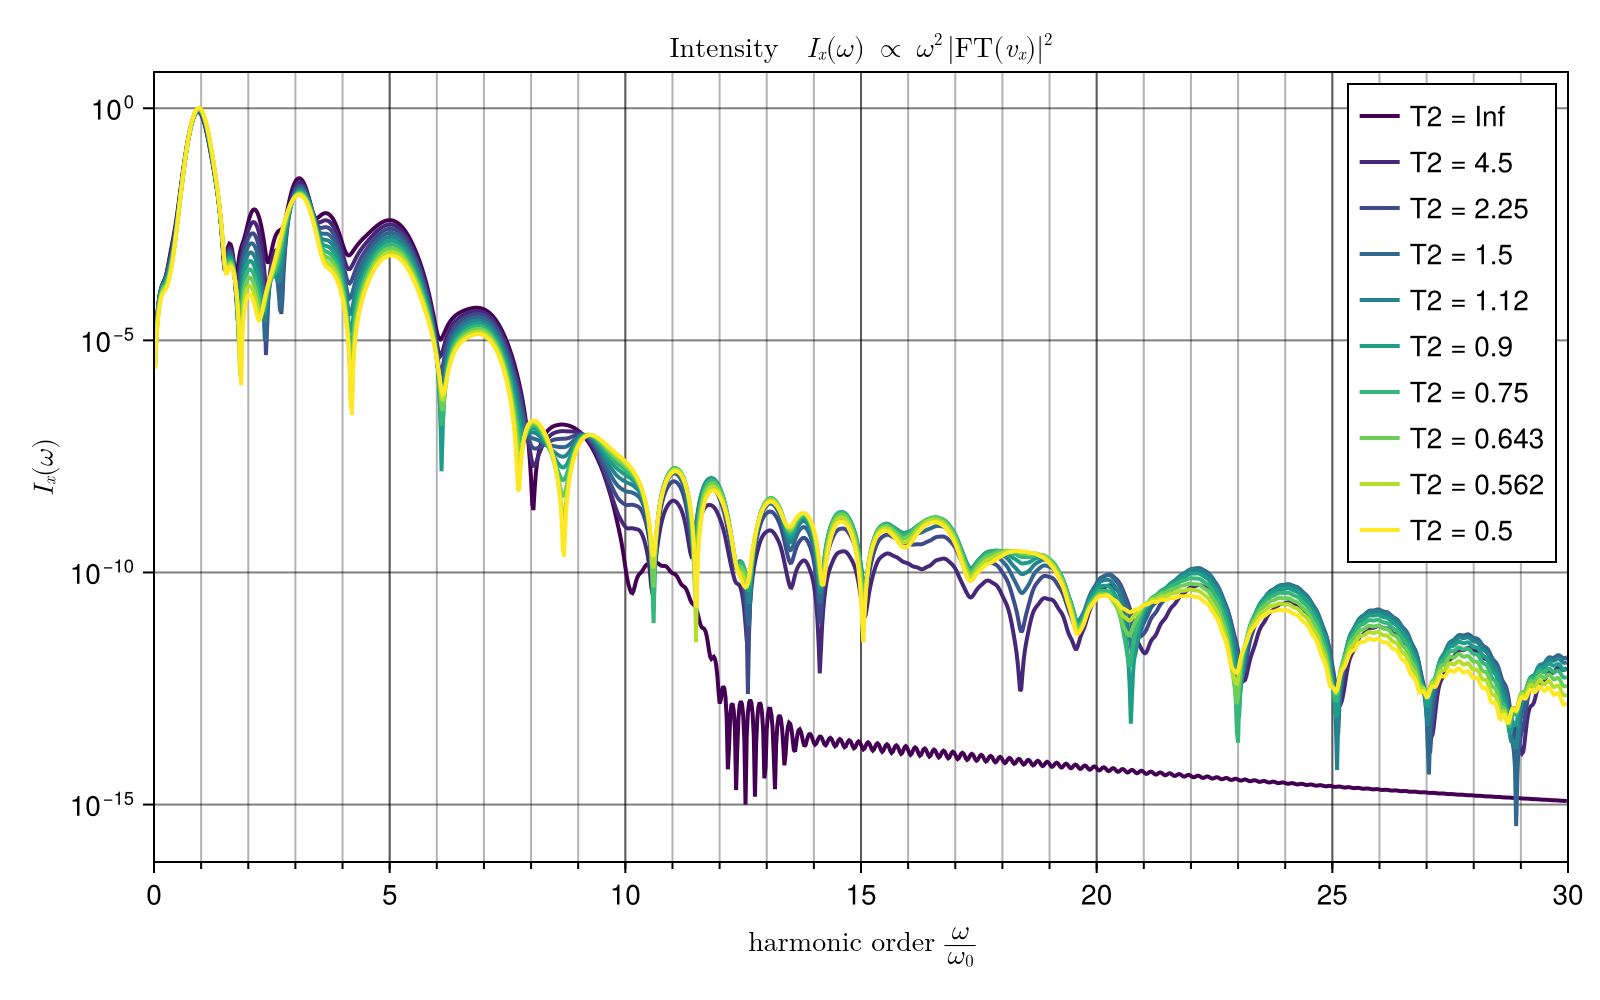

In [130]:
t2sweep   = Figure(size=(800,500))
maxharm = 30
darkgrey = RGBAf(0,0,0,0.5)
lightgrey = RGBAf(0,0,0,0.3)
ax  = Axis(t2sweep[1,1],yscale=log10,xlabel=L"\text{harmonic order } \frac{\omega}{\omega_0}",ylabel=L"I_x(ω)",
    title=L"\text{Intensity   } I_x(\omega)~\propto ~\omega^2\,\left|\text{FT}(v_x)\right|^2",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=lightgrey,
    yminorgridcolor=lightgrey,
    xgridcolor=darkgrey,
    ygridcolor=darkgrey,
    xminorticks=0:1:maxharm,
    xticks=0:5:maxharm)
inds = 0 .< fre .< maxharm
for (i,tot,s) in zip(1:length(sims),vxpdgs,sims)
    lines!(ax,fre[inds],tot.power[inds] .* (fre[inds] .^2) ./ maximum(vxpdg.power);
        label="T2 = $(round(getparams(s).t2,sigdigits=3))",
        linewidth=2,
        color=i,
        colorrange=(1,length(sims)))
end
axislegend(ax)
xlims!(ax,0,maxharm)
t2sweep

In [131]:
CairoMakie.save("vx_t2sweep_1.png",t2sweep)

CairoMakie.Screen{IMAGE}


In [132]:
CairoMakie.save("vx_t2sweep_1.svg",t2sweep)

CairoMakie.Screen{SVG}


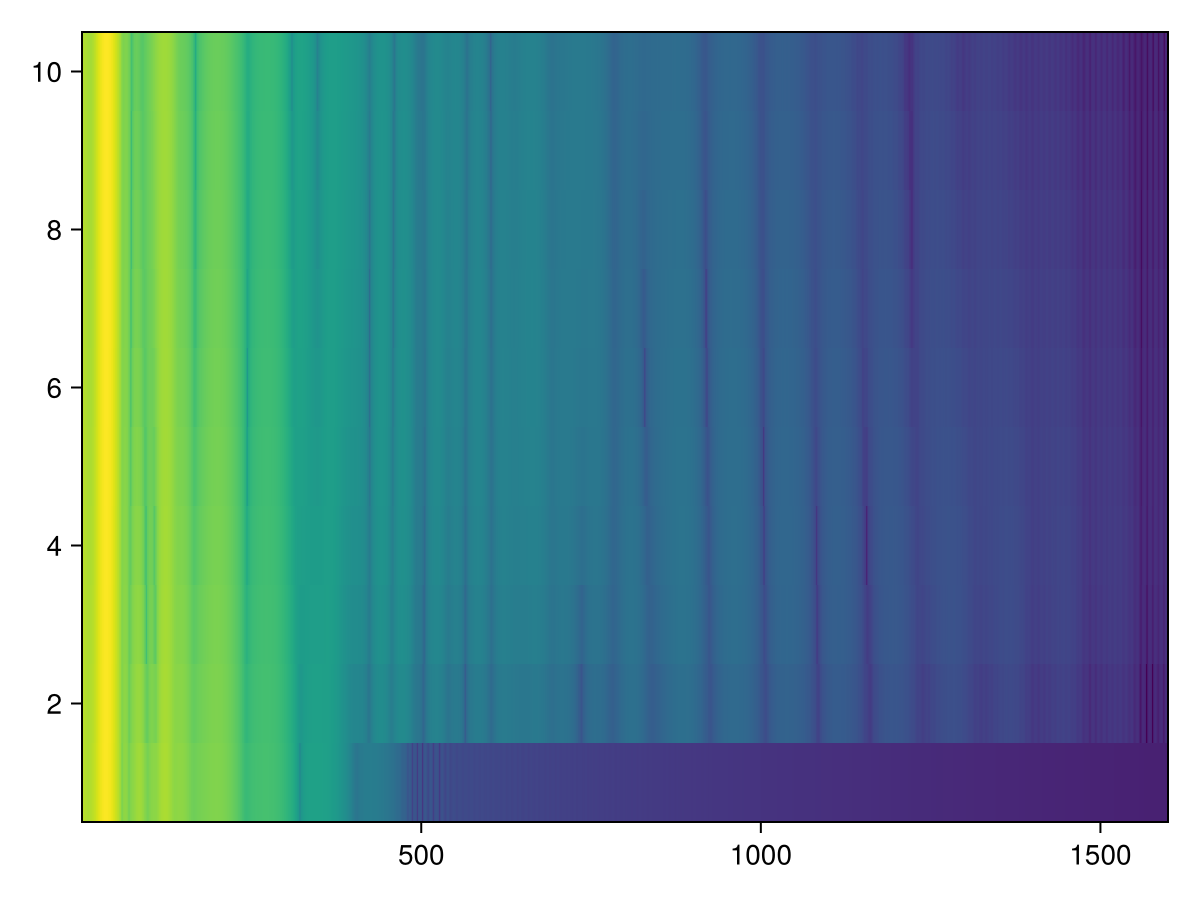

In [94]:
powmat = hcat([log10.(p.power[0 .< fre .< 40]) for p in vxpdgs]...)
heatmap(powmat)

# Spectra as function of parameters

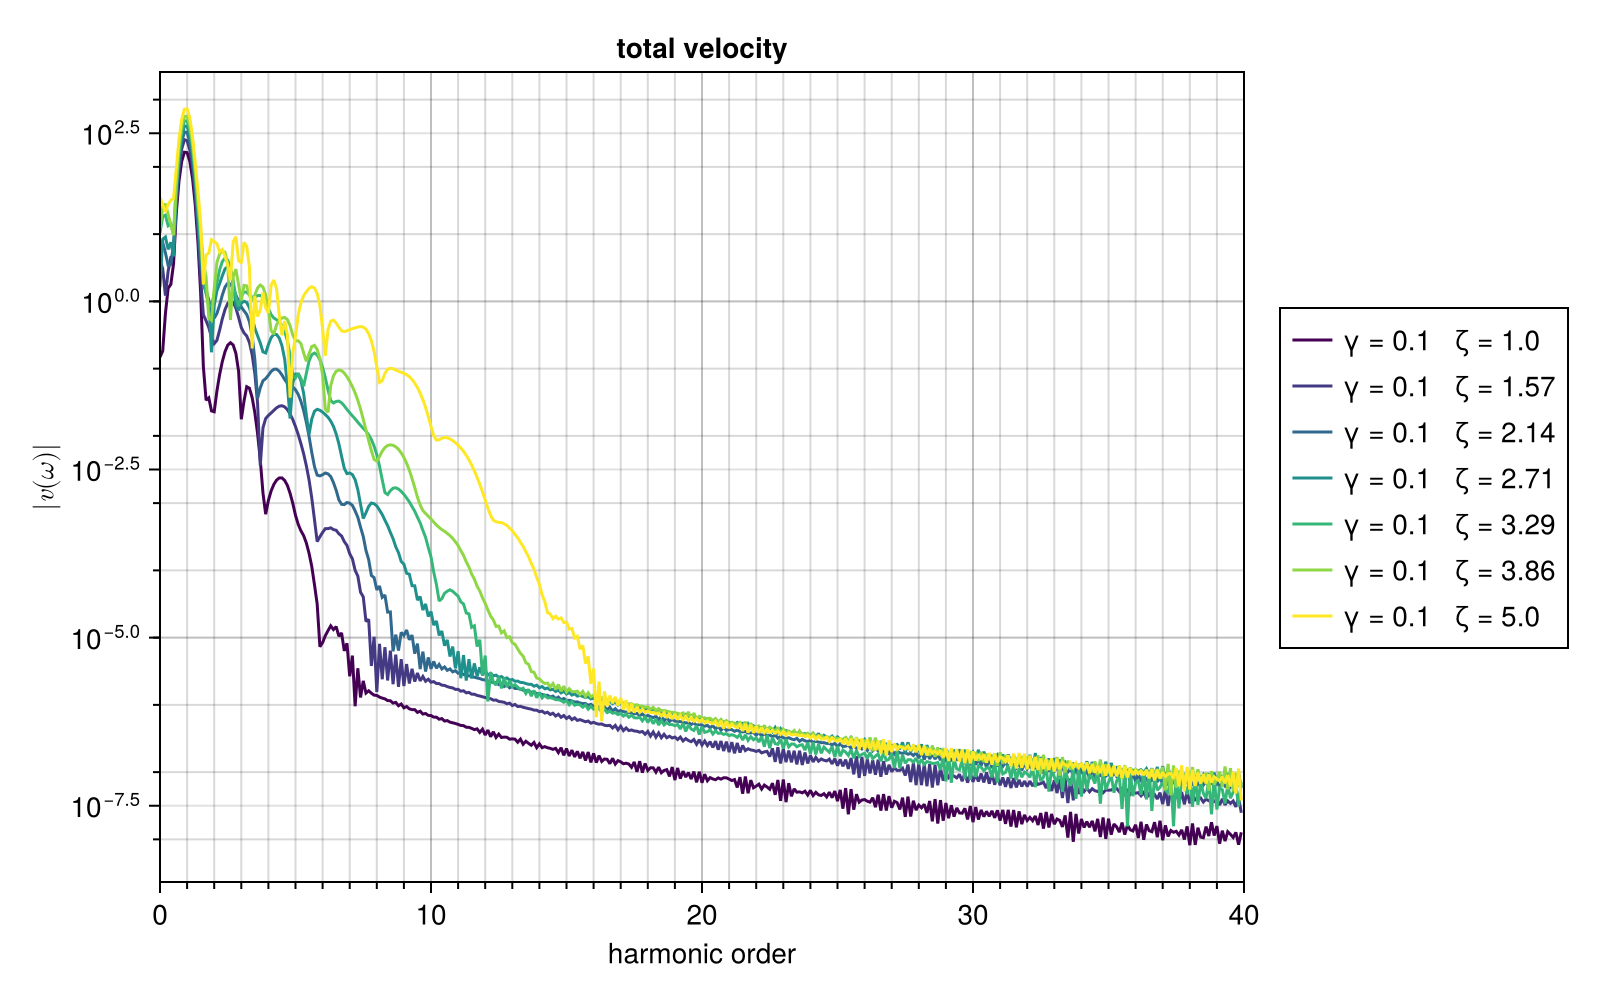

In [14]:
f   = Figure(size=(800,500))
ax  = Axis(f[1,1],yscale=log10,xlabel="harmonic order",ylabel=L"|v(ω)|",title="total velocity",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=RGBAf(0,0,0,0.15),
    yminorgridcolor=RGBAf(0,0,0,0.15),
    xminorticks=0:100,
    yminorticksvisible=true,
    yminorgridvisible=true,
    yminorticks=[10.0^j for j in -20:10])
for (i,d,fre,p) in zip(1:7,fftvx,freqs,parameters)
    inds = abs.(d) .> 1e-30 .&& fre .< 40.0
    lines!(ax,fre[inds],abs.(d[inds]);color=i,colorrange=(1,7),label="γ = $(p[1])   ζ = $(p[2])")
end
xlims!(ax,0,40)
f[1,2] = Legend(f,ax)
f

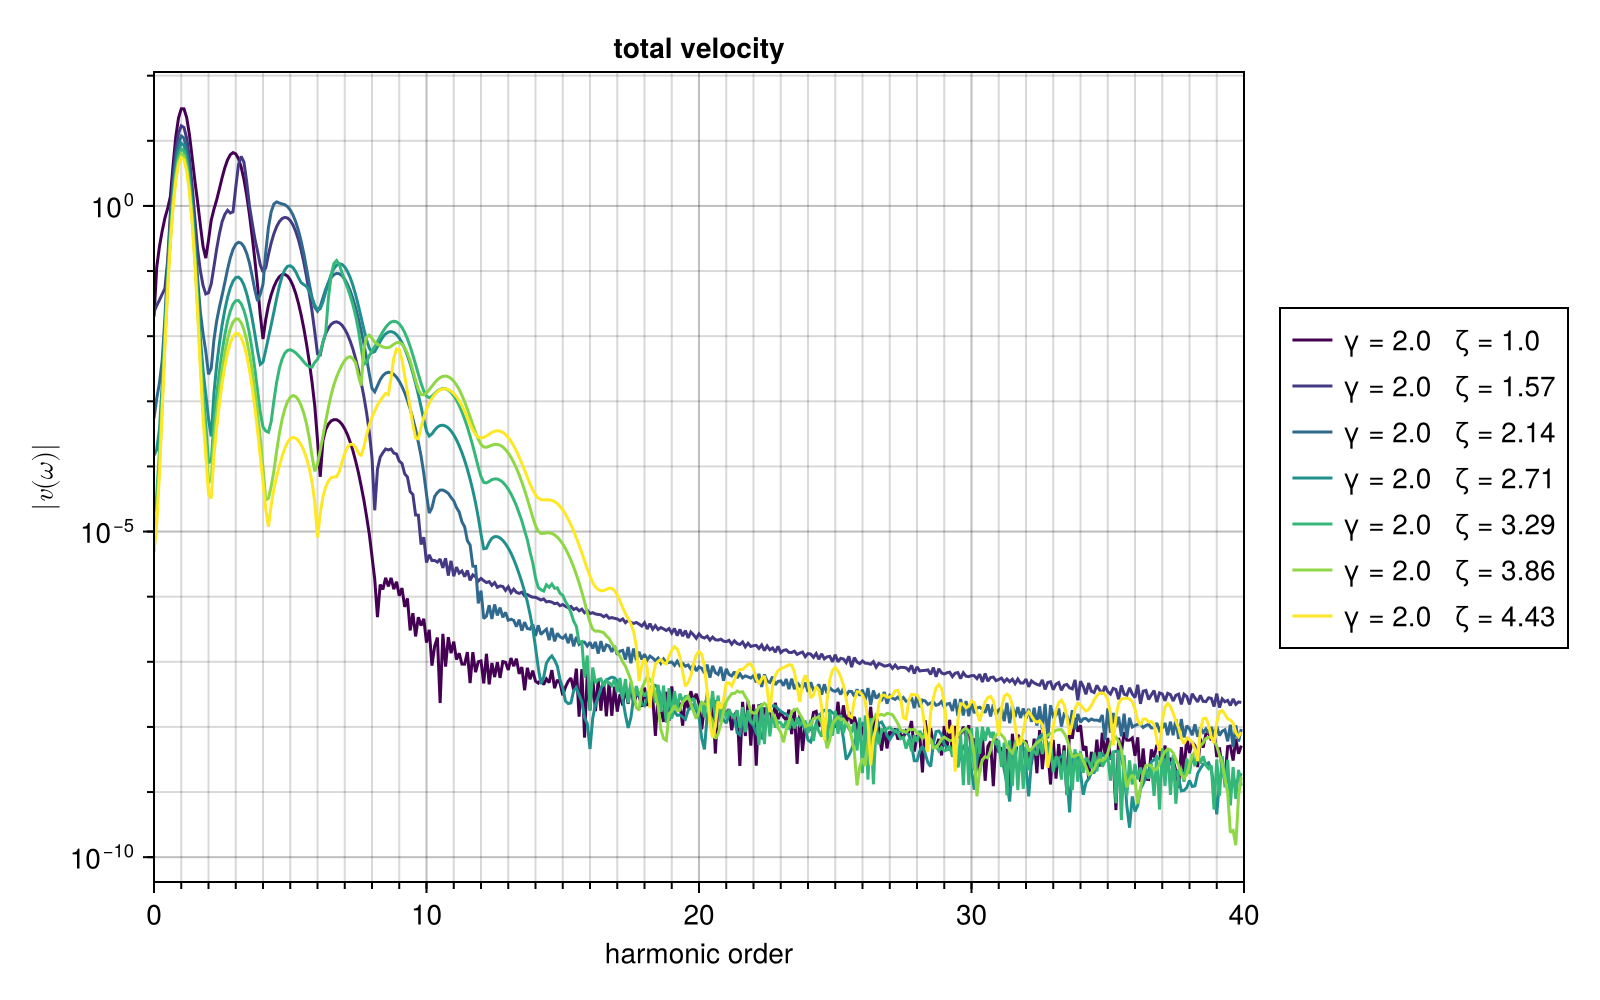

In [15]:
f   = Figure(size=(800,500))
ax  = Axis(f[1,1],yscale=log10,xlabel="harmonic order",ylabel=L"|v(ω)|",title="total velocity",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=RGBAf(0,0,0,0.15),
    yminorgridcolor=RGBAf(0,0,0,0.15),
    xminorticks=0:100,
    yminorticksvisible=true,
    yminorgridvisible=true,
    yminorticks=[10.0^j for j in -20:10])
for (i,d,fre,p) in zip(1:7,fftvx[end-7:end],freqs[end-7:end],parameters[end-7:end])
    inds = abs.(d) .> 1e-30 .&& fre .< 40.0
    lines!(ax,fre[inds],abs.(d[inds]);color=i,colorrange=(1,7),label="γ = $(p[1])   ζ = $(p[2])")
end
xlims!(ax,0,40)
f[1,2] = Legend(f,ax)
f

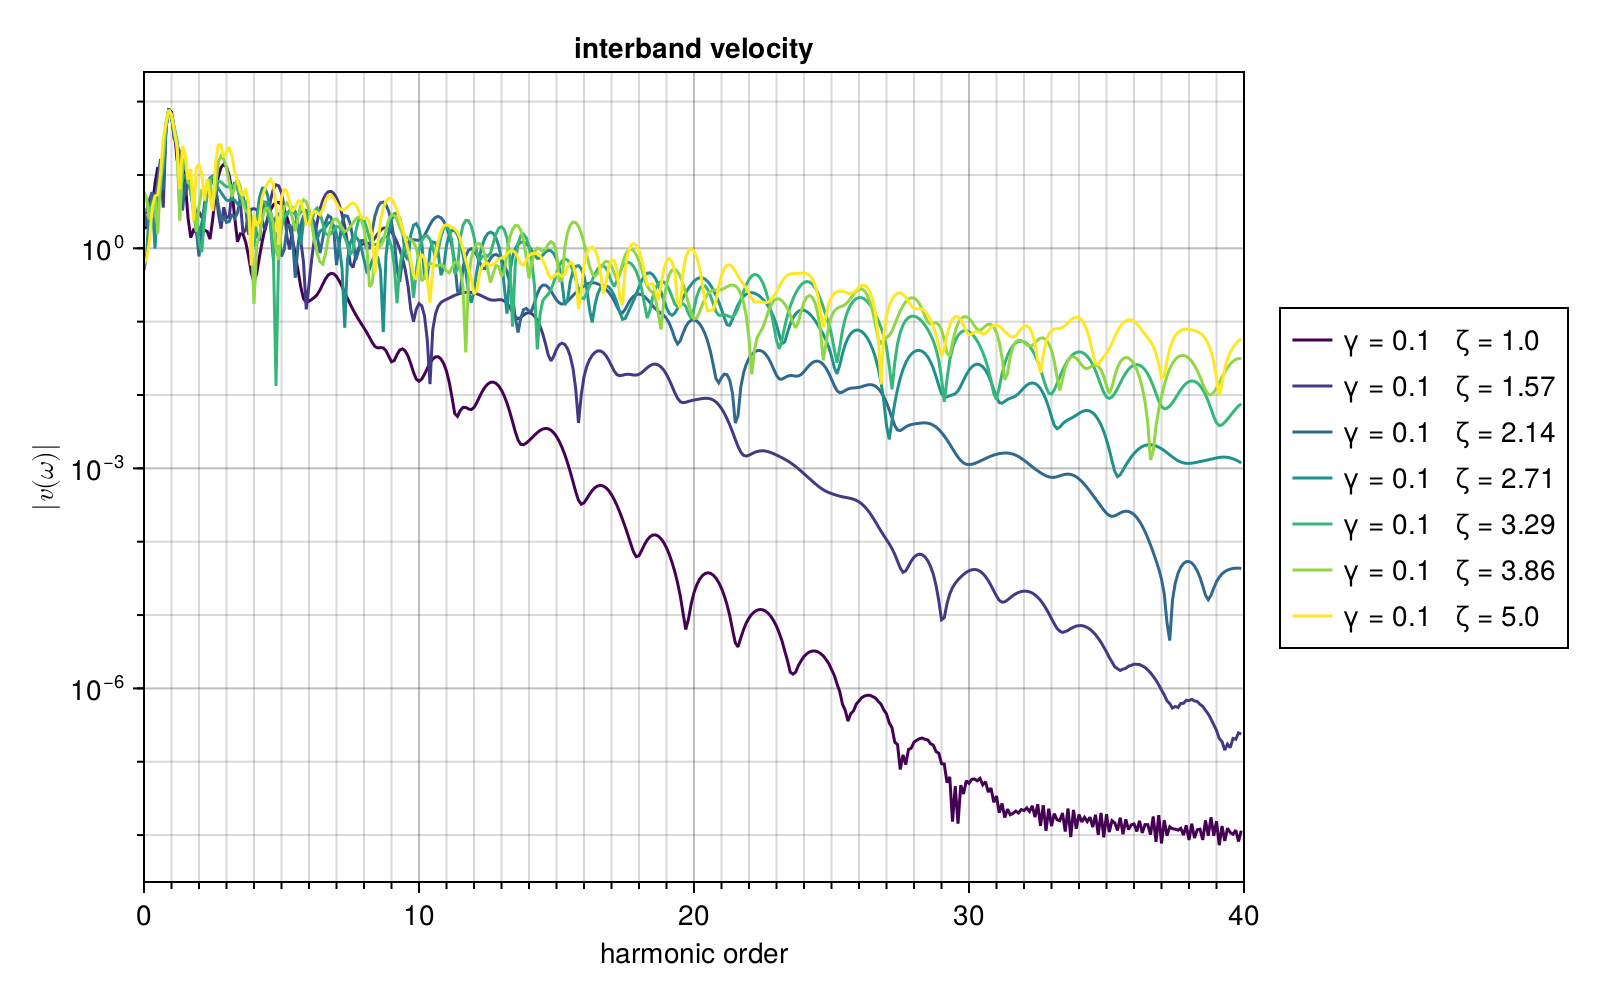

In [27]:
f   = Figure(size=(800,500))
ax  = Axis(f[1,1],yscale=log10,xlabel="harmonic order",ylabel=L"|v(ω)|",title="interband velocity",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=RGBAf(0,0,0,0.15),
    yminorgridcolor=RGBAf(0,0,0,0.15),
    xminorticks=0:100,
    yminorticksvisible=true,
    yminorgridvisible=true,
    yminorticks=[10.0^j for j in -20:10])
for (i,d,fre,p) in zip(1:7,fftvxer,freqs,parameters)
    inds = abs.(d) .> 1e-30 .&& fre .< 40.0
    lines!(ax,fre[inds],abs.(d[inds]);color=i,colorrange=(1,7),label="γ = $(p[1])   ζ = $(p[2])")
end
xlims!(ax,0,40)
f[1,2] = Legend(f,ax)
f

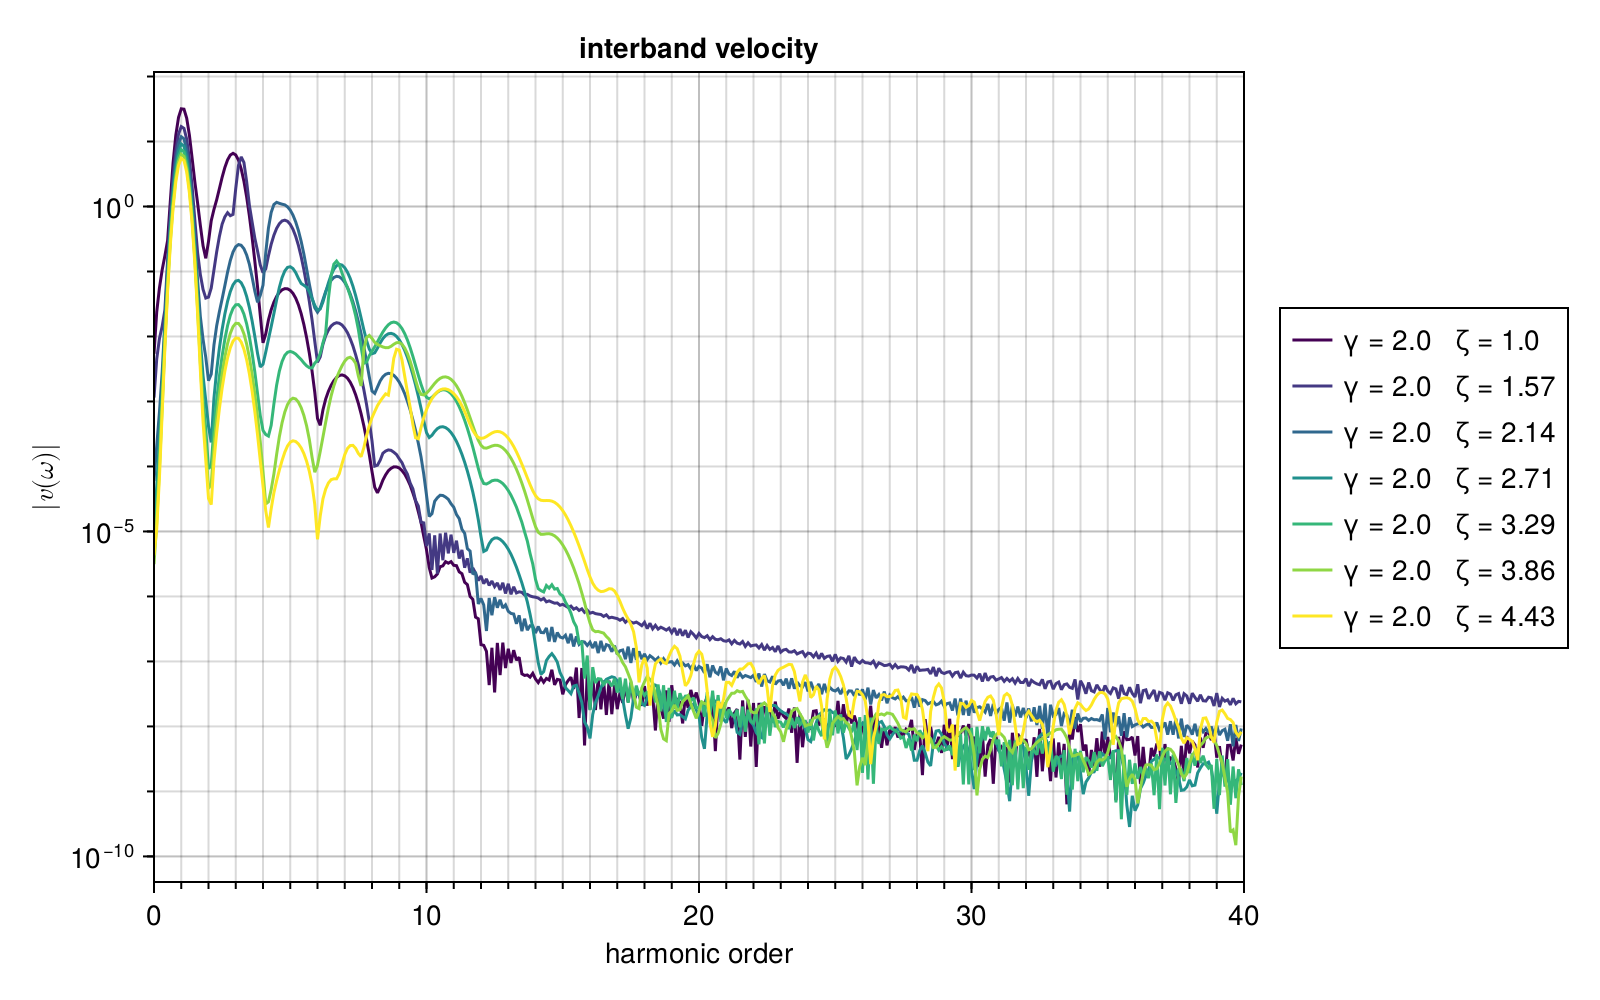

In [73]:
f   = Figure(size=(800,500))
ax  = Axis(f[1,1],yscale=log10,xlabel="harmonic order",ylabel=L"|v(ω)|",title="interband velocity",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=RGBAf(0,0,0,0.15),
    yminorgridcolor=RGBAf(0,0,0,0.15),
    xminorticks=0:100,
    yminorticksvisible=true,
    yminorgridvisible=true,
    yminorticks=[10.0^j for j in -20:10])
for (i,d,fre,p) in zip(1:7,fftvxer[end-7:end],freqs[end-7:end],parameters[end-7:end])
    inds = abs.(d) .> 1e-30 .&& fre .< 40.0
    lines!(ax,fre[inds],abs.(d[inds]);color=i,colorrange=(1,7),label="γ = $(p[1])   ζ = $(p[2])")
end
xlims!(ax,0,40)
f[1,2] = Legend(f,ax)
f

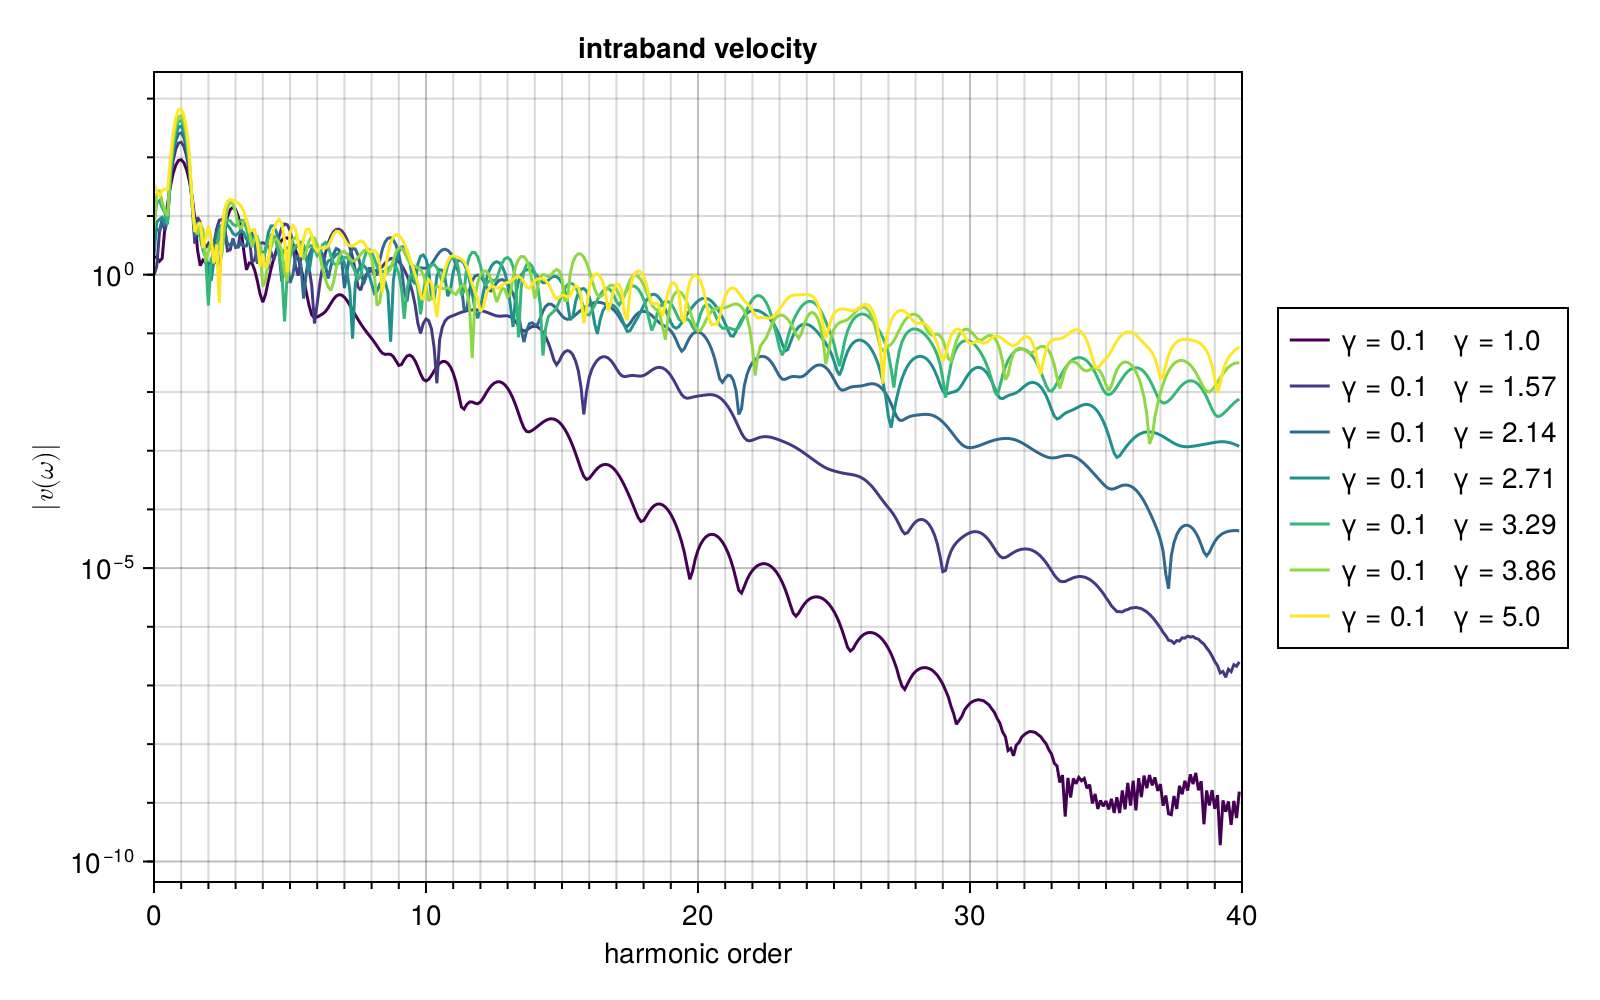

In [29]:
f   = Figure(size=(800,500))
ax  = Axis(f[1,1],yscale=log10,xlabel="harmonic order",ylabel=L"|v(ω)|",title="intraband velocity",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=RGBAf(0,0,0,0.15),
    yminorgridcolor=RGBAf(0,0,0,0.15),
    xminorticks=0:100,
    yminorticksvisible=true,
    yminorgridvisible=true,
    yminorticks=[10.0^j for j in -20:10])
for (i,d,fre,p) in zip(1:7,fftvxra,freqs,parameters)
    inds = abs.(d) .> 1e-30 .&& fre .< 40.0
    lines!(ax,fre[inds],abs.(d[inds]);color=i,colorrange=(1,7),label="γ = $(p[1])   γ = $(p[2])")
end
xlims!(ax,0,40)
f[1,2] = Legend(f,ax)
f

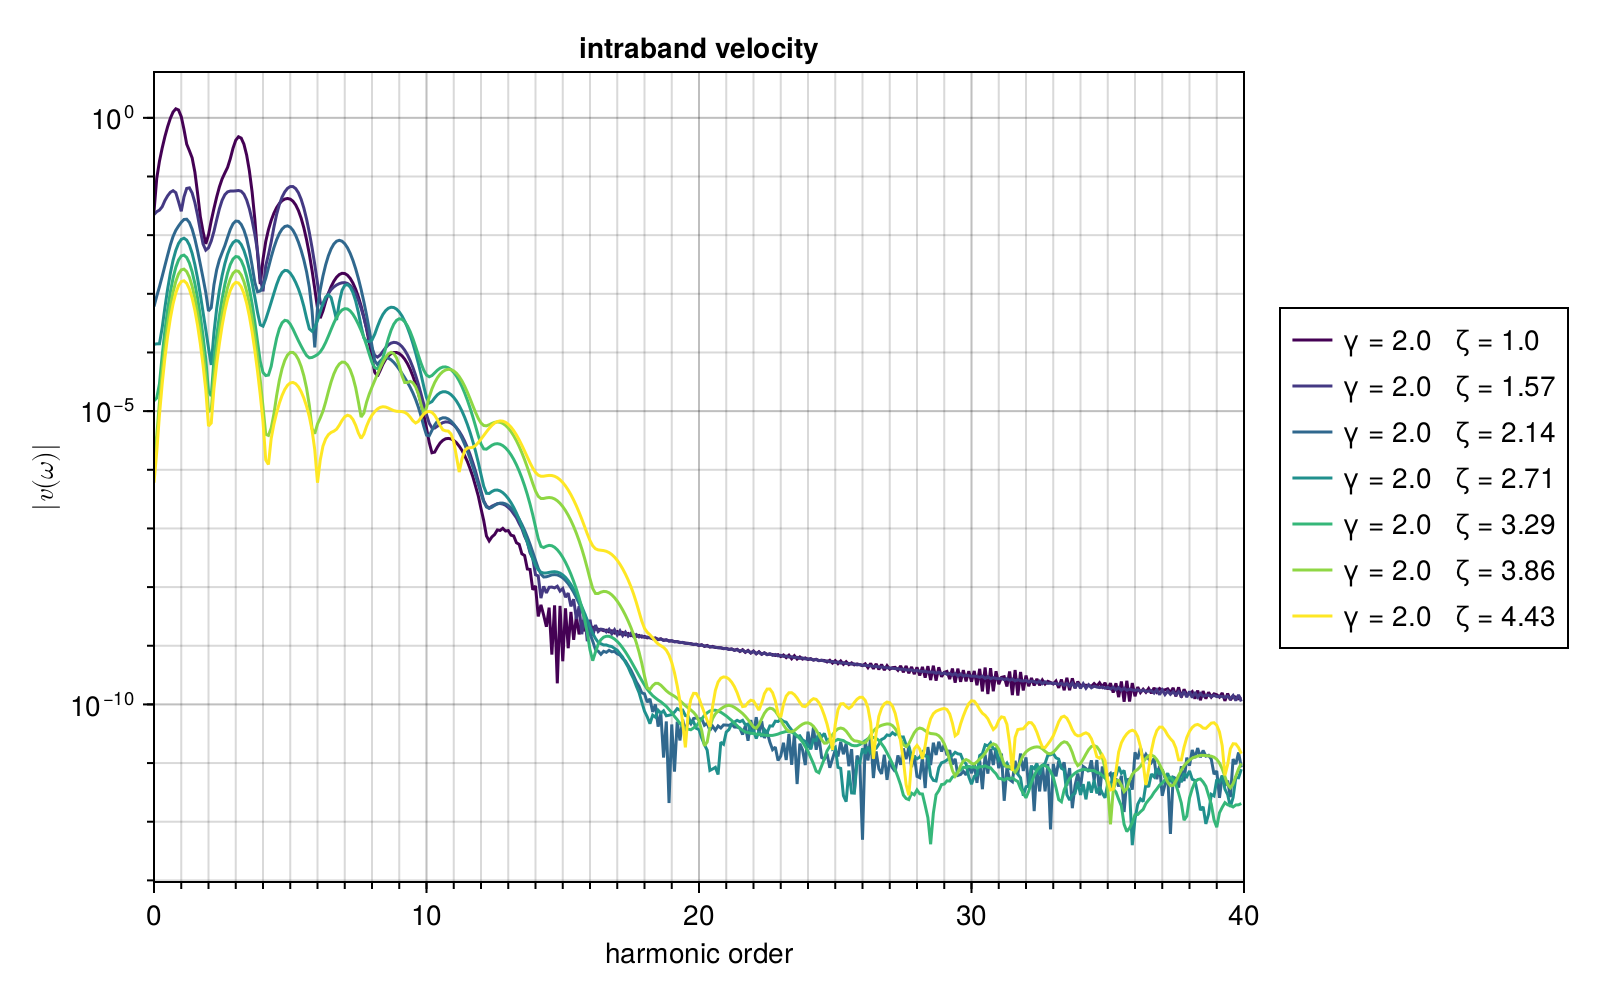

In [75]:
f   = Figure(size=(800,500))
ax  = Axis(f[1,1],yscale=log10,xlabel="harmonic order",ylabel=L"|v(ω)|",title="intraband velocity",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=RGBAf(0,0,0,0.15),
    yminorgridcolor=RGBAf(0,0,0,0.15),
    xminorticks=0:100,
    yminorticksvisible=true,
    yminorgridvisible=true,
    yminorticks=[10.0^j for j in -20:10])
for (i,d,fre,p) in zip(1:7,fftvxra[end-7:end],freqs[end-7:end],parameters[end-7:end])
    inds = abs.(d) .> 1e-30 .&& fre .< 40.0
    lines!(ax,fre[inds],abs.(d[inds]);color=i,colorrange=(1,7),label="γ = $(p[1])   ζ = $(p[2])")
end
xlims!(ax,0,40)
f[1,2] = Legend(f,ax)
f

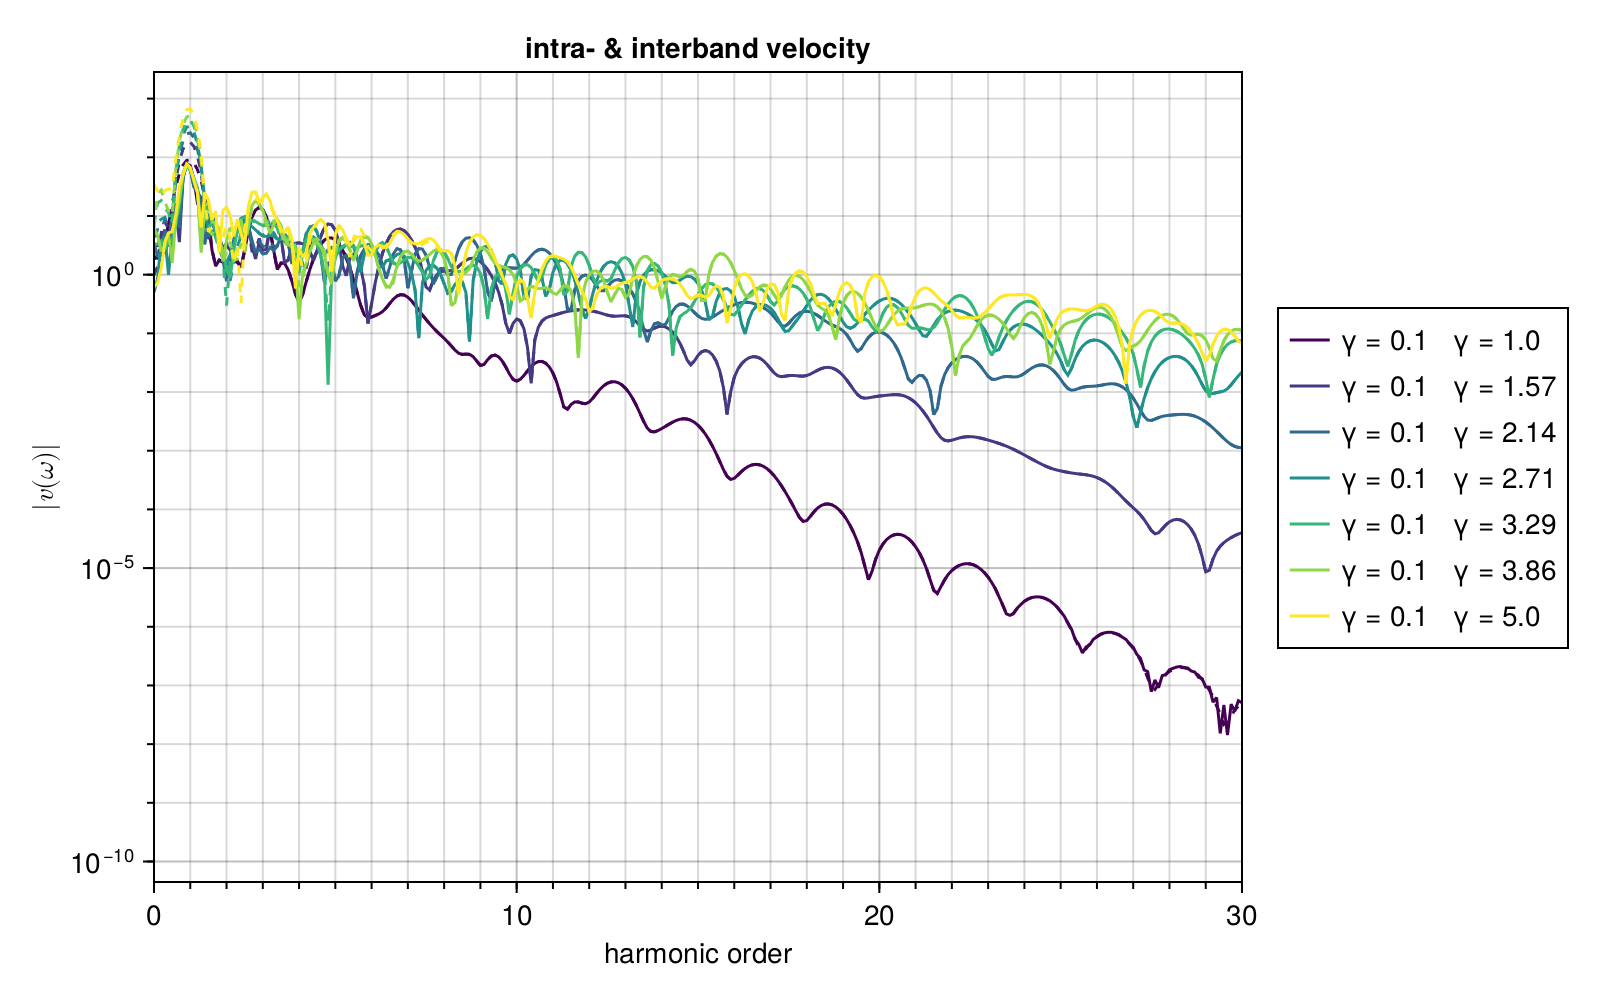

In [35]:
f   = Figure(size=(800,500))
ax  = Axis(f[1,1],yscale=log10,xlabel="harmonic order",ylabel=L"|v(ω)|",title="intra- & interband velocity",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=RGBAf(0,0,0,0.15),
    yminorgridcolor=RGBAf(0,0,0,0.15),
    xminorticks=0:100,
    yminorticksvisible=true,
    yminorgridvisible=true,
    yminorticks=[10.0^j for j in -20:10])
for (i,der,dra,fre,p) in zip(1:7,fftvxer,fftvxra,freqs,parameters)
    inds = abs.(der) .> 1e-30 .&& fre .< 40.0
    lines!(ax,fre[inds],abs.(der[inds]);color=i,colorrange=(1,7),label="γ = $(p[1])   γ = $(p[2])")
    lines!(ax,fre[inds],abs.(dra[inds]);color=i,colorrange=(1,7),linestyle=:dash)
end
xlims!(ax,0,30)
f[1,2] = Legend(f,ax)
f

# Simple measure for cancellation phenomenon: ratios of inter/total and inter/intra

## Define & test measure

In [156]:
function intertotalratio(i::Integer) 
    inds = 5 .< freqs[i] .< 20
    return avg(log.(abs2.(fftvxer[i][inds]) ./ abs2.(fftvx[i][inds])))
end
function interintraratio(i::Integer) 
    inds = 5 .< freqs[i] .< 20
    return avg(log.(abs2.(fftvxer[i][inds]) ./ abs2.(fftvxra[i][inds])))
end
intertotalratio(::Missing) = missing
interintraratio(::Missing) = missing

interintraratio (generic function with 3 methods)

In [140]:
for i in 1:7
    inds = 5 .< freqs[i] .< 20
    println("ζ = $(parameters[i][2]) γ =  $(parameters[i][1])")
    println("log(|vxinter|^2 / |vx|^2)      = $(intertotalratio(i))")
    println("log(|vxinter|^2 / |vxintra|^2) = $(interintraratio(i))\n")
end

ζ = 1.0 γ =  0.1
log(|vxinter|^2 / |vx|^2)      = 18.401445589345812
log(|vxinter|^2 / |vxintra|^2) = -0.00010790763158945745

ζ = 1.57 γ =  0.1
log(|vxinter|^2 / |vx|^2)      = 21.847479639118383
log(|vxinter|^2 / |vxintra|^2) = 0.00012821215975129214

ζ = 2.14 γ =  0.1
log(|vxinter|^2 / |vx|^2)      = 22.50494679070409
log(|vxinter|^2 / |vxintra|^2) = -0.00010797686761613966

ζ = 2.71 γ =  0.1
log(|vxinter|^2 / |vx|^2)      = 21.26267929338956
log(|vxinter|^2 / |vxintra|^2) = 0.002154815072579514

ζ = 3.29 γ =  0.1
log(|vxinter|^2 / |vx|^2)      = 20.217804344774937
log(|vxinter|^2 / |vxintra|^2) = 0.0013612116775943912

ζ = 3.86 γ =  0.1
log(|vxinter|^2 / |vx|^2)      = 18.760489763996993
log(|vxinter|^2 / |vxintra|^2) = 0.004904512150175354

ζ = 5.0 γ =  0.1
log(|vxinter|^2 / |vx|^2)      = 14.996847838799695
log(|vxinter|^2 / |vxintra|^2) = -0.007930246300011155



In [141]:
for i in 54:60
    inds = 5 .< freqs[i] .< 20
    println("ζ = $(parameters[i][2]) γ =  $(parameters[i][1])")
    println("log(|vxinter|^2 / |vx|^2)      = $(intertotalratio(i))")
    println("log(|vxinter|^2 / |vxintra|^2) = $(interintraratio(i))\n")
end

ζ = 1.57 γ =  2.0
log(|vxinter|^2 / |vx|^2)      = 0.18884838312561933
log(|vxinter|^2 / |vxintra|^2) = 5.563487138615186

ζ = 2.14 γ =  2.0
log(|vxinter|^2 / |vx|^2)      = -0.051343268426717395
log(|vxinter|^2 / |vxintra|^2) = 7.104084807425252

ζ = 2.71 γ =  2.0
log(|vxinter|^2 / |vx|^2)      = 0.001477421914326616
log(|vxinter|^2 / |vxintra|^2) = 6.97267597833323

ζ = 3.29 γ =  2.0
log(|vxinter|^2 / |vx|^2)      = -0.038839450454489985
log(|vxinter|^2 / |vxintra|^2) = 7.935520254707339

ζ = 3.86 γ =  2.0
log(|vxinter|^2 / |vx|^2)      = -0.04275479132601437
log(|vxinter|^2 / |vxintra|^2) = 7.874499771538934

ζ = 4.43 γ =  2.0
log(|vxinter|^2 / |vx|^2)      = -0.04602038979635688
log(|vxinter|^2 / |vxintra|^2) = 8.250313532561448

ζ = 5.0 γ =  2.0
log(|vxinter|^2 / |vx|^2)      = -0.050983680659371804
log(|vxinter|^2 / |vxintra|^2) = 7.748422163904018



In [150]:
function getparindex(γ,ζ,data)
    for (i,d) in enumerate(data)
        if γ ≈ d[1] && ζ ≈ d[2]
            return i
        end
    end
    return missing
end
getparindex(g,z) = getparindex(g,z,parameters)

getparindex (generic function with 2 methods)

In [162]:
zetas = Set([p[2] for p in parameters]) |> collect |> sort
gammas = Set([p[1] for p in parameters])  |> collect |> sort

8-element Vector{Float64}:
 0.1
 0.371
 0.643
 0.914
 1.19
 1.46
 1.73
 2.0

In [163]:
parmat = [(g,z) for g in gammas,z in zetas]

8×8 Matrix{Tuple{Float64, Float64}}:
 (0.1, 1.0)    (0.1, 1.57)    (0.1, 2.14)    …  (0.1, 4.43)    (0.1, 5.0)
 (0.371, 1.0)  (0.371, 1.57)  (0.371, 2.14)     (0.371, 4.43)  (0.371, 5.0)
 (0.643, 1.0)  (0.643, 1.57)  (0.643, 2.14)     (0.643, 4.43)  (0.643, 5.0)
 (0.914, 1.0)  (0.914, 1.57)  (0.914, 2.14)     (0.914, 4.43)  (0.914, 5.0)
 (1.19, 1.0)   (1.19, 1.57)   (1.19, 2.14)      (1.19, 4.43)   (1.19, 5.0)
 (1.46, 1.0)   (1.46, 1.57)   (1.46, 2.14)   …  (1.46, 4.43)   (1.46, 5.0)
 (1.73, 1.0)   (1.73, 1.57)   (1.73, 2.14)      (1.73, 4.43)   (1.73, 5.0)
 (2.0, 1.0)    (2.0, 1.57)    (2.0, 2.14)       (2.0, 4.43)    (2.0, 5.0)

In [164]:
intertotalratio.(getparindex.(gammas,zetas'))

8×8 Matrix{Union{Missing, Float64}}:
 18.4014   21.8475    22.5049     …  18.7605        missing   14.9968
 15.416      missing  13.7412        10.0432       8.06061     6.50974
  9.08321   8.20028   10.1578          missing     4.09198     2.46949
  4.66947   7.53663    4.048          1.84946      0.648329    0.589617
  2.91704   5.27842    1.25358        0.00791904   0.193727   -0.0260617
  2.74958   1.27711    1.29201    …  -0.0904623   -0.0534653  -0.044899
  2.33413   0.414788   0.657996      -0.0472191   -0.0434013  -0.0514203
  2.42366   0.188848  -0.0513433     -0.0427548   -0.0460204  -0.0509837

## Plot as heatmaps

In [193]:
intertotalratio(γ,ζ) = intertotalratio(getparindex(γ,ζ))
interintraratio(γ,ζ) = interintraratio(getparindex(γ,ζ))

interintraratio (generic function with 4 methods)

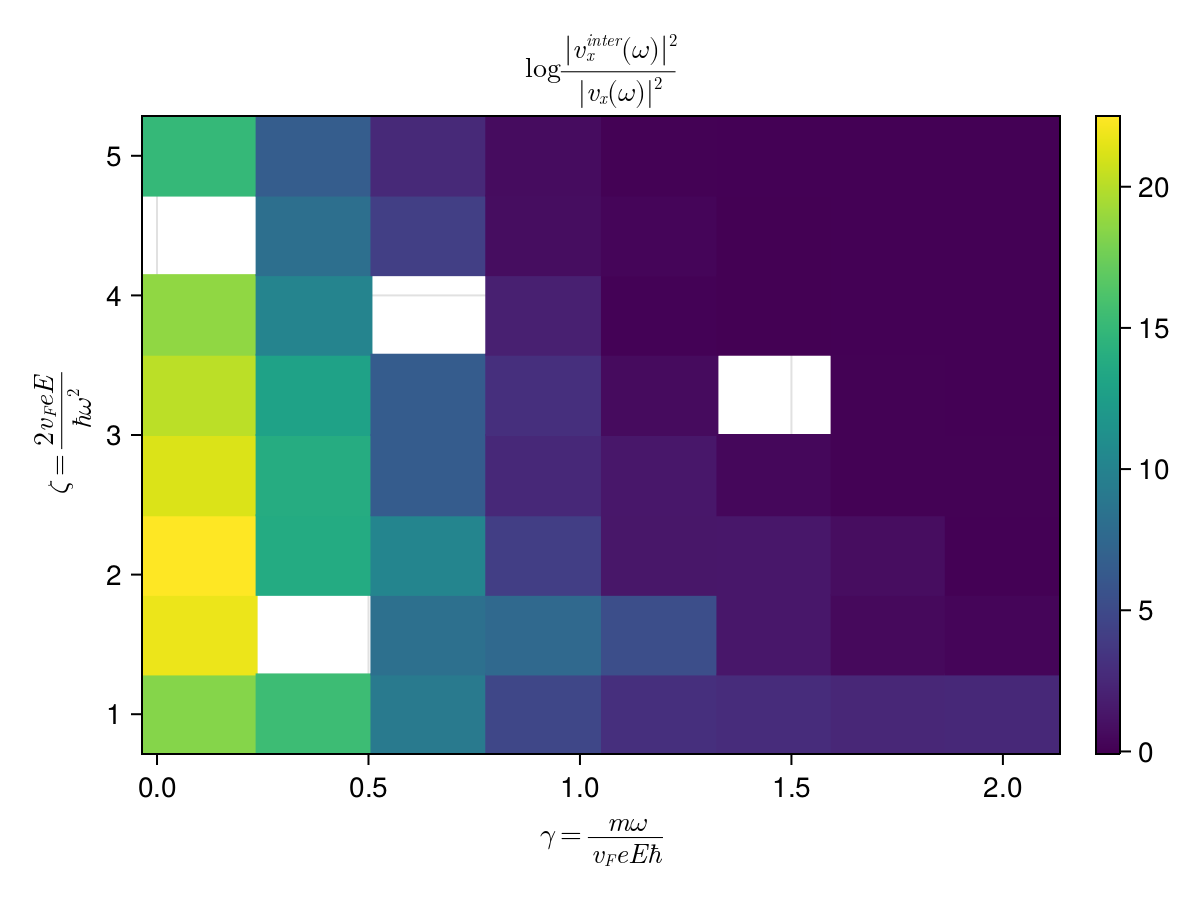

In [198]:
f = Figure()
ax = Axis(f[1,1],
    xlabel=L"\gamma=\frac{m\omega}{v_FeE\hbar}",
    ylabel=L"\zeta=\frac{2v_FeE}{\hbar\omega^2}",
    title=L"\log\frac{\left| v_x^{inter}(\omega)\right|^2}{\left| v_x(\omega)\right|^2}")
hm = heatmap!(ax,gammas,zetas,intertotalratio.(gammas,zetas'))
Colorbar(f[:,end+1],hm)
f

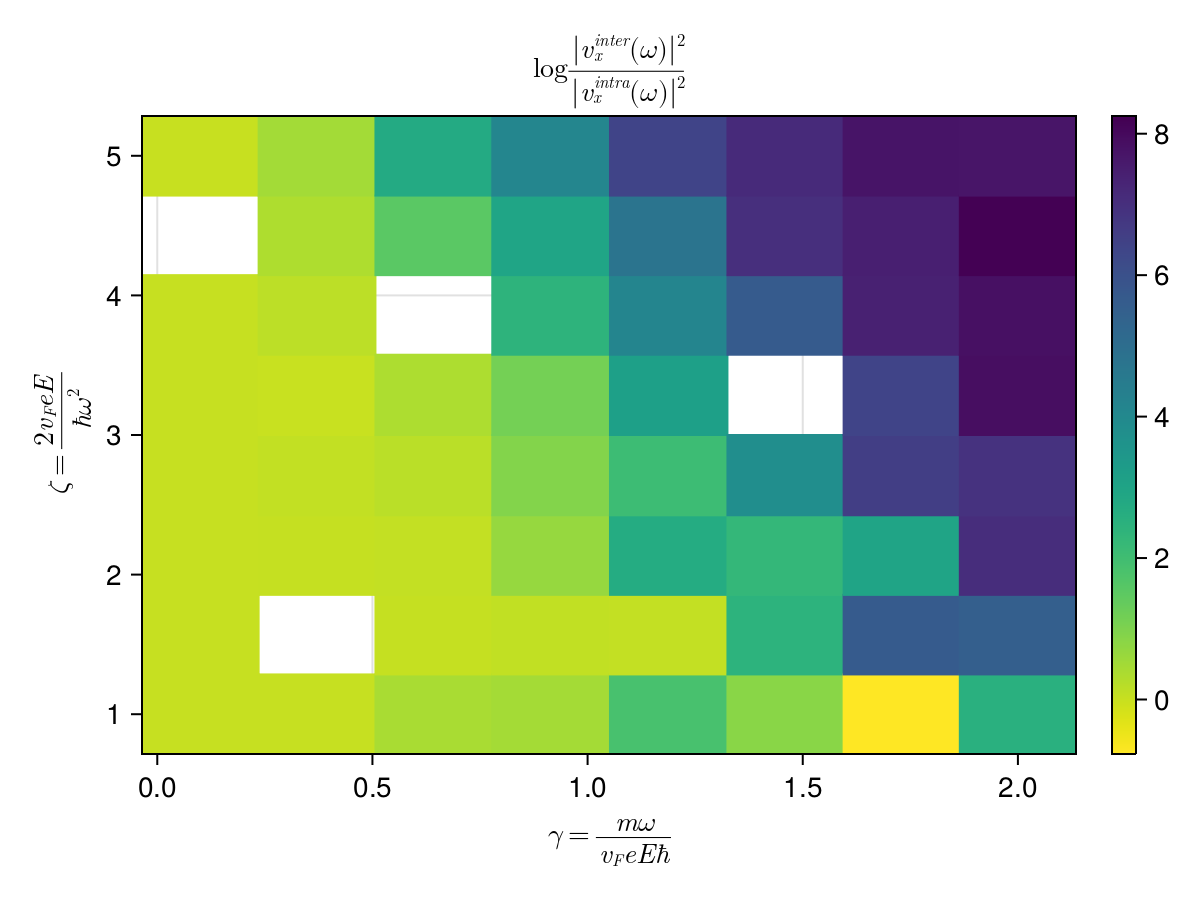

In [197]:
f = Figure()
ax = Axis(f[1,1],
    xlabel=L"\gamma=\frac{m\omega}{v_FeE\hbar}",
    ylabel=L"\zeta=\frac{2v_FeE}{\hbar\omega^2}",
    title=L"\log\frac{\left| v_x^{inter}(\omega)\right|^2}{\left| v_x^{intra}(\omega)\right|^2}")
hm = heatmap!(ax,gammas,zetas,interintraratio.(gammas,zetas'),colormap=Reverse(:viridis))
Colorbar(f[:,end+1],hm)
f